In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('autoscout24-germany-dataset.csv')

In [3]:
df.head()

mileage        make   model      fuel    gear offerType  price     hp  year
0   235000         BMW     316    Diesel  Manual      Used   6800  116.0  2011
1    92800  Volkswagen    Golf  Gasoline  Manual      Used   6877  122.0  2011
2   149300        SEAT    Exeo  Gasoline  Manual      Used   6900  160.0  2011
3    96200     Renault  Megane  Gasoline  Manual      Used   6950  110.0  2011
4   156000     Peugeot     308  Gasoline  Manual      Used   6950  156.0  2011

In [4]:
df.isnull().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

In [5]:
df.describe()

mileage         price            hp          year
count  4.640500e+04  4.640500e+04  46376.000000  46405.000000
mean   7.117786e+04  1.657234e+04    132.990987   2016.012951
std    6.262531e+04  1.930470e+04     75.449284      3.155214
min    0.000000e+00  1.100000e+03      1.000000   2011.000000
25%    1.980000e+04  7.490000e+03     86.000000   2013.000000
50%    6.000000e+04  1.099900e+04    116.000000   2016.000000
75%    1.050000e+05  1.949000e+04    150.000000   2019.000000
max    1.111111e+06  1.199900e+06    850.000000   2021.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


In [7]:
df['model'] = df['model'].fillna('Unknown')

most_common_gear = df['gear'].mode()[0]
df['gear'] = df['gear'].fillna(most_common_gear)

df['hp'] = df['hp'].fillna(df['hp'].median())

In [8]:
df.isnull().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
year         0
dtype: int64

In [9]:
df.describe()

mileage         price            hp          year
count  4.640500e+04  4.640500e+04  46405.000000  46405.000000
mean   7.117786e+04  1.657234e+04    132.980368   2016.012951
std    6.262531e+04  1.930470e+04     75.426900      3.155214
min    0.000000e+00  1.100000e+03      1.000000   2011.000000
25%    1.980000e+04  7.490000e+03     86.000000   2013.000000
50%    6.000000e+04  1.099900e+04    116.000000   2016.000000
75%    1.050000e+05  1.949000e+04    150.000000   2019.000000
max    1.111111e+06  1.199900e+06    850.000000   2021.000000

In [10]:
from datetime import datetime

current_year = datetime.now().year

df['car_age'] = current_year - df['year']

print(df[['year', 'car_age']].head())

   year  car_age
0  2011       14
1  2011       14
2  2011       14
3  2011       14
4  2011       14


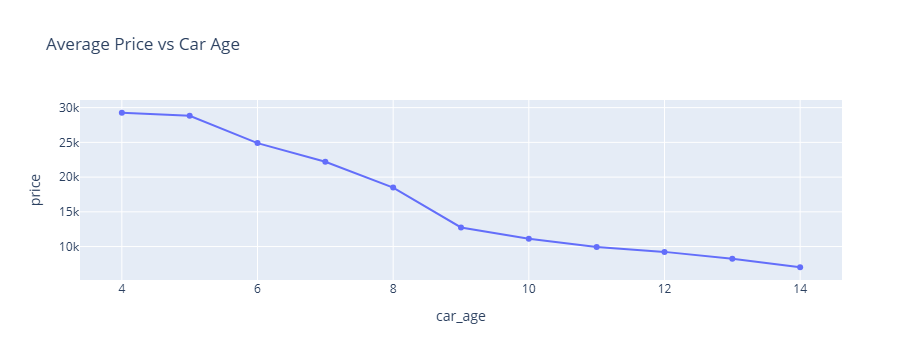

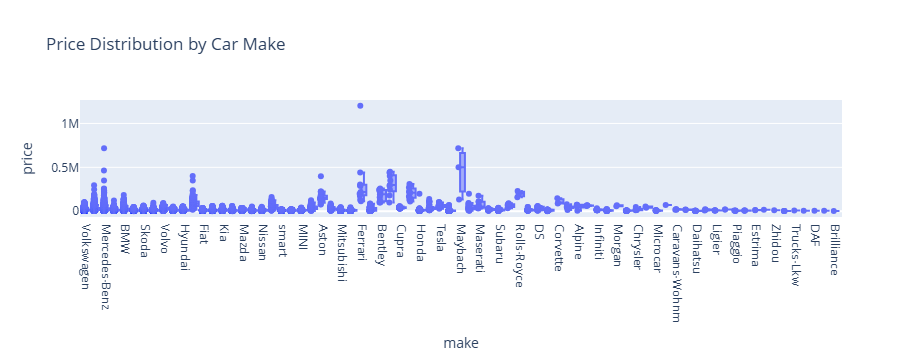

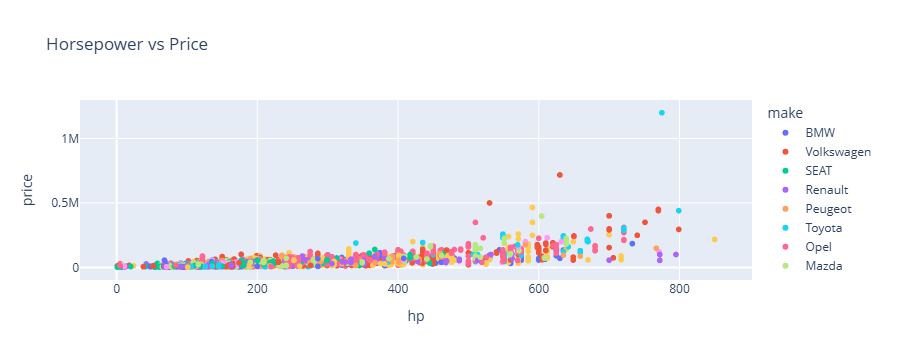

In [11]:
import plotly.express as px

# 1. Average price by car age
avg_price_age = df.groupby('car_age')['price'].mean().reset_index()
fig1 = px.line(avg_price_age, x='car_age', y='price',
               title='Average Price vs Car Age',
               markers=True)
fig1.show()

# 2. Price distribution by make
fig2 = px.box(df, x='make', y='price',
              title='Price Distribution by Car Make',
              points='all')
fig2.update_xaxes(categoryorder='total descending')  # Sort by price
fig2.show()

# 3. Horsepower vs Price trend
fig3 = px.scatter(df, x='hp', y='price',
                  color='make',
                  title='Horsepower vs Price',
                  hover_data=['model', 'year'])
fig3.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

features = ['mileage', 'make', 'model', 'fuel', 'gear', 'hp', 'car_age']
target = 'price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = ['mileage', 'hp', 'car_age']
categorical_features = ['make', 'model', 'fuel', 'gear']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

from sklearn.ensemble import RandomForestRegressor

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, random_state=42
    ))
])

model.fit(X_train, y_train)

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 1938.3457491281945
R²: 0.8185512141240086


In [ ]:
# XGBoost Regressor pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,       # number of trees
        learning_rate=0.05,     # step size shrinkage
        max_depth=8,            # depth of each tree
        subsample=0.8,          # row sampling
        colsample_bytree=0.8,   # feature sampling
        random_state=42
    ))
])

# Train
xgb_model.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R²:", r2_score(y_test, y_pred_xgb))